<a href="https://colab.research.google.com/github/Grandi9/AppleStockLSTM/blob/master/AAPL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This program uses Recurrent neural network called - LSTM
# I am using LSTM since it has Long term price dependencies
# LSTM's are useful since we can give relavant weights to the important data in the past
# We use this LSTM to predict the stock price of AAPL (Apple Inc) 
# i am using the past 60 days stock price.

In [1]:
# Import the libs

import math
import pandas_datareader as web #for reading the data
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #using keras
from keras.layers import Dense, LSTM #importing LSTMs
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') #specfic style of the matplot

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#get the stock prices and respective dates from yahoo finance
df = web.DataReader('AAPL', data_source='yahoo', start ='2012-01-01', end='2020-09-05')

#show the snapshot of data
#the missing dates are Saturdays, SUndays or Public Holidays
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.691425
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.759631
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.901293
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.036158
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,13.015480
...,...,...,...,...,...,...
2020-08-31,131.000000,126.000000,127.580002,129.039993,225702700.0,129.039993
2020-09-01,134.800003,130.529999,132.759995,134.179993,152470100.0,134.179993
2020-09-02,137.979996,127.000000,137.589996,131.399994,200119000.0,131.399994


In [3]:
#number of rows and columns in our dataset
df.shape

(2184, 6)

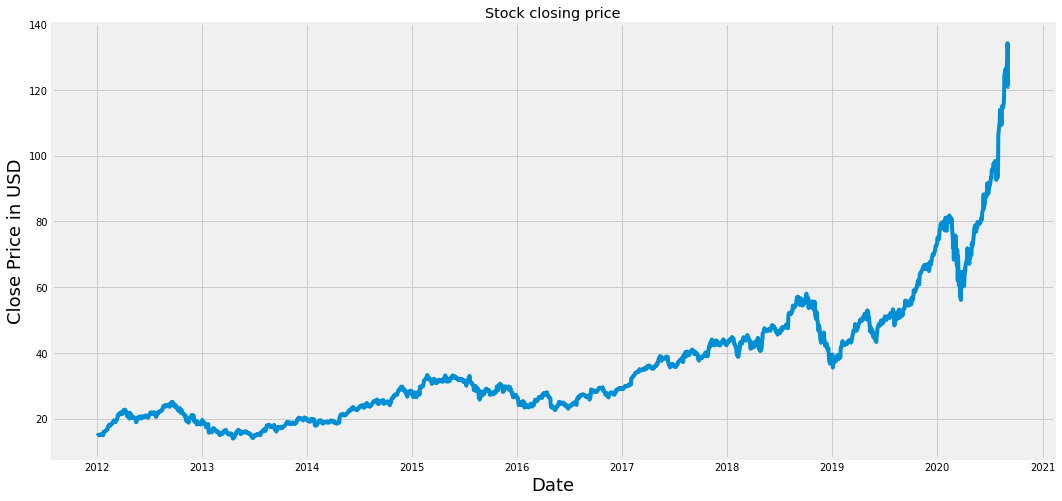

In [4]:
#visuvalize the closing price Date vs Price
plt.figure(figsize=(16,8))
plt.title('Stock closing price')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in USD', fontsize=18)
plt.show()

In [5]:
# new dataframe with only close column
data = df.filter(['Close'])

#convert into numpy array
dataset =data.values

#assign 80% of the data rows to train the model on
training_data_len = math.ceil(len(dataset) *0.8)

training_data_len #checking 


1748

In [6]:
#scale the data : pre-processing data
#making the range to be in 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0061488 ],
       [0.00680527],
       [0.00816869],
       ...,
       [0.97687814],
       [0.88938102],
       [0.89004641]])

In [7]:
#create the training dataset
#create the scaled training data
train_data = scaled_data[0:training_data_len , :]

#split data into x_train and y_train datasets
x_train = []
y_train = [] 

#x_train will contain past 60 days data for example (index 0 to index 59)
#y_train will contain next day data for example (index 60)
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])


In [8]:
#converting x-train and y-train to numpy
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#reshape the data
#lstm needs data as 3 dimensions and x_train has only 2

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1688, 60, 1)

In [11]:
#build the LSTM 
#two lstm layers with 50 neurons each
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False)) #false because it is the last layer

#dense layers
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#complie the model
#optimizer adam is for improving the loss fun
#loss fun is a benchmark on how the model did on training
model.compile(optimizer='adam', loss ='mean_squared_error')

In [13]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1688/1688 [==============================] - 31s 18ms/step - loss: 2.9011e-04


In [14]:
#create the testing dataset
#create a new array which has sacaled values from index 1684 to 2179
test_data = scaled_data[training_data_len - 60: ,:]

#create the datasets
x_test = [] #for past 60 values
y_test = dataset[training_data_len: , :] #all remaining values
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [15]:
#converting x-test to numpy
x_test = np.array(x_test)

In [16]:
#reshape the data
#lstm needs data as 3 dimensions and x_train has only 2

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
#x_test.shape

In [17]:
#get the models predicted pricing values
predictions = model.predict(x_test)

#undoing the scaling 
#so that the predictions contain the smae values as y_dataset
predictions = scaler.inverse_transform(predictions)

In [18]:
#evaluvate the model
#using (RSME)
rsme = np.sqrt( np.mean( predictions - y_test)**2)
rsme

#this rsme is a good value, considering the abnormal increase in AAPL due to COVID 

3.8014748949523365

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


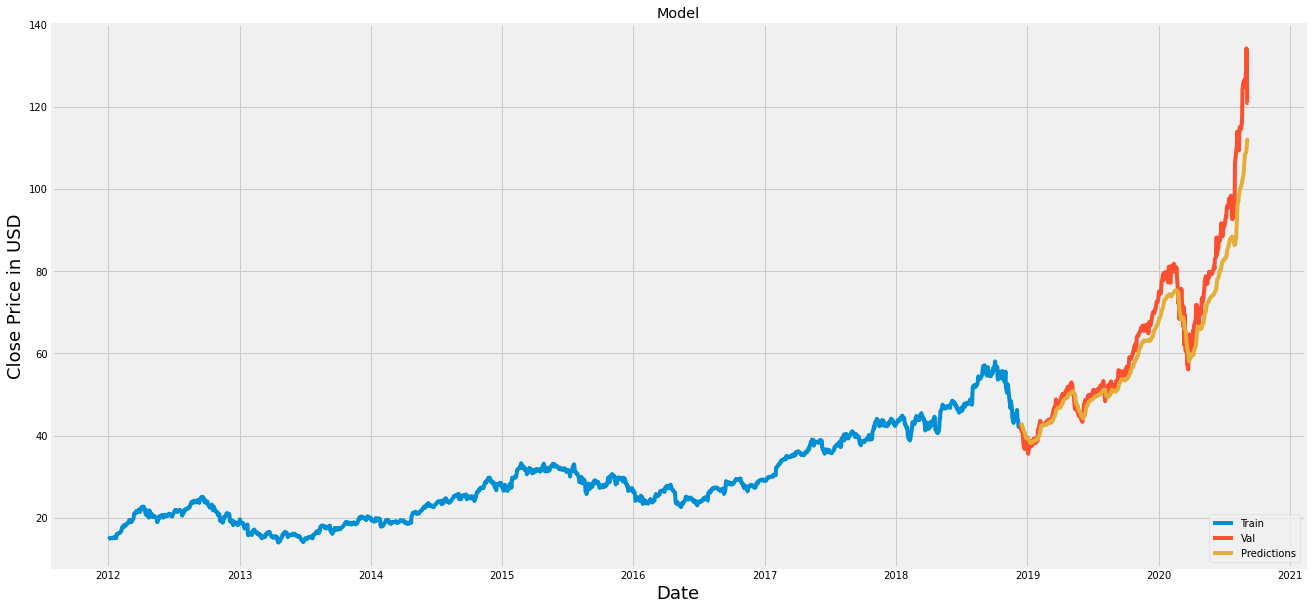

In [19]:
#plotting the data
train = data[:training_data_len]
valid = data[training_data_len:] #validation dataset
valid['Predictions'] = predictions

#visuvalize the model
plt.figure(figsize=(20,10))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
#show the actual price vs predicted prices
valid

,Close,Predictions
Date,,
2018-12-13,42.737499,43.076351
2018-12-14,41.369999,42.873589
2018-12-17,40.985001,42.602314
2018-12-18,41.517502,42.289436
2018-12-19,40.222500,42.052868
...,...,...
2020-08-31,129.039993,108.915512
2020-09-01,134.179993,109.668915
2020-09-02,131.399994,110.964943


In [22]:
#get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-09-03')

#create a new dataframe
new_df = apple_quote.filter(['Close'])

#get the last 60 day closing price values
#convert dataframe into an array
last_60_days = new_df[-60:].values

#scale data so that values are btw 0 and 1 using the same values as eariler
last_60_days_scaled = scaler.transform(last_60_days)

X_test=[]
#append past the 60 days 
X_test.append(last_60_days_scaled)

#convert the X-test to numpy
X_test = np.array(X_test)

#reshaping so that dimensions match
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#getting predicted scaled price
pred_price = model.predict(X_test)

#undoing the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[111.547905]]


In [23]:
#get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-09-04', end='2020-09-04')
print(apple_quote2['Close'])

Date
2020-09-04    120.959999
Name: Close, dtype: float64
